In [32]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy.crs  as ccrs
import os
import datetime
from datetime import timedelta
from datetime import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import geopandas as gp
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import linregress
import matplotlib.patches as patches
import seaborn as sns

import WetBulb

GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [33]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

def standardize(x):
    return x/x.std(dim = 'time')

def CtoF(x):
    return x*9/5 + 32

# Load historical data

In [34]:
stn_folder = '/dx01/ivanov/data/HadISD_stationdata/brazil_heatwave/raw_station_data/'

# Rio stations
galeao_name = 'hadisd.3.4.0.2023f_19310101-20240101_837460-99999.nc'
galeao = xr.open_dataset(stn_folder + galeao_name)

In [35]:
file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
    
    if year <= 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_PBE_historical_an-sfc_' + str(year) + '_0UTC.nc'
    
    if year > 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_historical_an-sfc_' + str(year) + '_0UTC.nc'
        
    filenames.append(file_name)

# Open all files
temp_dailymax = xr.open_mfdataset(filenames)

In [36]:
temp_dailymax = temp_dailymax.rename_vars({'T': 't2m'})

In [37]:
# Just open 2023 data

file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

temp_2023 = xr.open_mfdataset(file_dir + 'T_daily_max_ERA5_historical_an-sfc_2023_0UTC.nc')

In [38]:
# Combine ERA5 and ERA5T
temp2023_ERA5 = temp_2023.sel(expver=1)

temp2023_ERA5T = temp_2023.sel(expver = 5)

temp2023_ERA5 = temp2023_ERA5.isel(time = slice(0, 304))
temp2023_ERA5T = temp2023_ERA5T.isel(time = slice(304,366))

temp2023_combined = xr.combine_by_coords([temp2023_ERA5,temp2023_ERA5T])

In [39]:
# Historical data
temp_combined = xr.combine_by_coords([temp_dailymax,temp2023_combined.drop_vars('expver')])

In [40]:
# Grid cell closest to Rio station location
lon_grid, lat_grid = np.meshgrid(temp_combined.longitude.values, temp_combined.latitude.values)
distances = np.sqrt((lon_grid - (galeao.longitude.values + 360))**2 + (lat_grid - galeao.latitude.values)**2)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

# Get the longitude and latitude of the closest grid cell
closest_lon = temp_combined.longitude.values[min_index[1]]
closest_lat = temp_combined.latitude.values[min_index[0]]

temp_rio = temp_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])

# Load projections data

In [41]:
# List of models with missing data for each time period
base_dir = '/dx02/data/NEXGDDP/rio_data/'
missing_hist = pd.read_csv(base_dir + 'missing_hist.txt', header = None)
missing_ssp126 = pd.read_csv(base_dir + 'missing_ssp126.txt', header = None)
missing_ssp245 = pd.read_csv(base_dir + 'missing_ssp245.txt', header = None)
missing_ssp370 = pd.read_csv(base_dir + 'missing_ssp370.txt', header = None)

In [42]:
all_missing = pd.concat([missing_hist, missing_ssp126,missing_ssp245,missing_ssp370], axis = 0, sort = False)
missing_models = np.unique(np.array(all_missing[0]))

In [43]:
high_skill_score_models = ['BCC-CSM2-MR', 'EC-Earth3', 'GFDL-ESM4', 'HadGEM3-GC31-MM',
                           'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']
high_score_no_missing = ['BCC-CSM2-MR', 'EC-Earth3', 'GFDL-ESM4','MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

In [44]:
# Open and stack all models from each scenario

base_dir_processed = base_dir + 'brazil_heatwave_processed_data/'

# Now bias correcting all periods

for subdir, dirs, files in os.walk(base_dir_processed + 'ssp126/'):
    
    for i in range(len(files)):
        
        file = files[i]
        
        if i == 0:
            data_ssp126 = pd.read_csv(base_dir_processed + 'ssp126/' + file, index_col = 0)
            data_ssp126['model'] = file.rsplit('_')[2]
            
        else:
            data_model = pd.read_csv(base_dir_processed + 'ssp126/' + file, index_col = 0)
            data_model['model'] = file.rsplit('_')[2]
            data_ssp126 = pd.concat([data_ssp126, data_model], axis = 0, sort = False)
            
# SSP245
for subdir, dirs, files in os.walk(base_dir_processed + 'ssp245/'):
    
    for i in range(len(files)):
        
        file = files[i]
        
        if i == 0:
            data_ssp245 = pd.read_csv(base_dir_processed + 'ssp245/' + file, index_col = 0)
            data_ssp245['model'] = file.rsplit('_')[2]
            
        else:
            data_model = pd.read_csv(base_dir_processed + 'ssp245/' + file, index_col = 0)
            data_model['model'] = file.rsplit('_')[2]
            data_ssp245 = pd.concat([data_ssp245, data_model], axis = 0, sort = False)
            
# SSP370
for subdir, dirs, files in os.walk(base_dir_processed + 'ssp370/'):
    
    for i in range(len(files)):
        
        file = files[i]
        
        if i == 0:
            data_ssp370 = pd.read_csv(base_dir_processed + 'ssp370/' + file, index_col = 0)
            data_ssp370['model'] = file.rsplit('_')[2]
            
        else:
            data_model = pd.read_csv(base_dir_processed + 'ssp370/' + file, index_col = 0)
            data_model['model'] = file.rsplit('_')[2]
            data_ssp370 = pd.concat([data_ssp370, data_model], axis = 0, sort = False)
            
# SSP585
for subdir, dirs, files in os.walk(base_dir_processed + 'ssp585/'):
    
    for i in range(len(files)):
        
        file = files[i]
        
        if i == 0:
            data_ssp585 = pd.read_csv(base_dir_processed + 'ssp585/' + file, index_col = 0)
            data_ssp585['model'] = file.rsplit('_')[2]
            
        else:
            data_model = pd.read_csv(base_dir_processed + 'ssp585/' + file, index_col = 0)
            data_model['model'] = file.rsplit('_')[2]
            data_ssp585 = pd.concat([data_ssp585, data_model], axis = 0, sort = False) 

In [45]:
# Remove data from models which are missing data in any scenario
data_ssp126_models = data_ssp126[~data_ssp126['model'].isin(missing_models)]
data_ssp245_models = data_ssp245[~data_ssp245['model'].isin(missing_models)]
data_ssp370_models = data_ssp370[~data_ssp370['model'].isin(missing_models)]
data_ssp585_models = data_ssp585[~data_ssp585['model'].isin(missing_models)]

In [46]:
# Remove data with wonky historical data (includes February 30th -- this may be a convention in the models in general)
wonky_date_models = ['HadGEM3-GC31-LL','HadGEM3-GC31-MM','KACE-1-0-G','UKESM1-0-LL']

data_ssp126_models = data_ssp126_models[~data_ssp126_models['model'].isin(wonky_date_models)]
data_ssp245_models = data_ssp245_models[~data_ssp245_models['model'].isin(wonky_date_models)]
data_ssp370_models = data_ssp370_models[~data_ssp370_models['model'].isin(wonky_date_models)]
data_ssp585_models = data_ssp585_models[~data_ssp585_models['model'].isin(wonky_date_models)]

In [47]:
# Total number of models remaining
print(len(np.unique(data_ssp245_models.model.values)))
print(len(np.unique(data_ssp585_models.model.values)))

23
23


## For Figure S3, Select only models which have high skill scores

In [37]:
# Skip this cell if want to go with all models with available data
# This will only use 6 different models for the analysis
data_ssp126_models = data_ssp126_models[data_ssp126_models.model.isin(high_skill_score_models)]
data_ssp245_models = data_ssp245_models[data_ssp245_models.model.isin(high_skill_score_models)]
data_ssp370_models = data_ssp370_models[data_ssp370_models.model.isin(high_skill_score_models)]
data_ssp585_models = data_ssp585_models[data_ssp585_models.model.isin(high_skill_score_models)]

In [48]:
# Take average across models
data_ssp126_avg = data_ssp126_models.drop(columns = ['model']).groupby(['date_mid_cent','time','date','date_end_cent']).mean()
data_ssp126_avg = data_ssp126_avg.reset_index()
data_ssp126_avg['date_end_cent'] = data_model.date_end_cent

data_ssp245_avg = data_ssp245_models.drop(columns = ['model']).groupby(['date_mid_cent','time','date','date_end_cent']).mean()
data_ssp245_avg = data_ssp245_avg.reset_index()
data_ssp245_avg['date_end_cent'] = data_model.date_end_cent

data_ssp370_avg = data_ssp370_models.drop(columns = ['model']).groupby(['date_mid_cent','time','date','date_end_cent']).mean()
data_ssp370_avg = data_ssp370_avg.reset_index()
data_ssp370_avg['date_end_cent'] = data_model.date_end_cent

data_ssp585_avg = data_ssp585_models.drop(columns = ['model']).groupby(['date_mid_cent','time','date','date_end_cent']).mean()
data_ssp585_avg = data_ssp585_avg.reset_index()
data_ssp585_avg['date_end_cent'] = data_model.date_end_cent

# Plot

In [50]:
temp_rio.load()

<xarray.Dataset>
Dimensions:  (time: 16436)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
Data variables:
    t2m      (time) float32 307.1 302.5 304.2 298.9 ... 303.3 309.4 302.3 298.1

# GEV analysis

In [51]:
from scipy.stats import genextreme as gev

T_early = temp_rio.sel(time = (temp_rio.time.dt.year < 1991) & (temp_rio.time.dt.year > 1980))
T_late = temp_rio.sel(time = temp_rio.time.dt.year > 2013)

Tspring_early = T_early.sel(time = T_early.time.dt.month.isin([9,10,11]))
Tspring_late = T_late.sel(time = T_late.time.dt.month.isin([9,10,11]))

early_color = 'cornflowerblue'
late_color = 'gold'
alpha = 0.15

plt.rcParams.update({'font.size': 14})

In [52]:
Tspring_early_yrmax = Tspring_early.resample(time="Y").max()
Tspring_late_yrmax = Tspring_late.resample(time="Y").max()

In [53]:
### SSP245
data_ssp245_avg['mid_cent_dates'] = pd.to_datetime(data_ssp245_avg.date_mid_cent)
data_ssp245_avg['end_cent_dates'] = pd.to_datetime(data_ssp245_avg.date_end_cent)
ssp245_spring = data_ssp245_avg[data_ssp245_avg.mid_cent_dates.dt.month.isin([9,10,11])]

ssp245_spring_mid = ssp245_spring[['tasmax_mid_cent','mid_cent_dates']].set_index('mid_cent_dates')
ssp245_spring_end = ssp245_spring[['tasmax_end_cent','end_cent_dates']].set_index('end_cent_dates')

# SSP585
data_ssp585_avg['mid_cent_dates'] = pd.to_datetime(data_ssp585_avg.date_mid_cent)
data_ssp585_avg['end_cent_dates'] = pd.to_datetime(data_ssp585_avg.date_end_cent)
ssp585_spring = data_ssp585_avg[data_ssp585_avg.mid_cent_dates.dt.month.isin([9,10,11])]

ssp585_spring_mid = ssp585_spring[['tasmax_mid_cent','mid_cent_dates']].set_index('mid_cent_dates')
ssp585_spring_end = ssp585_spring[['tasmax_end_cent','end_cent_dates']].set_index('end_cent_dates')

ssp245_spring_mid_yrmax = ssp245_spring_mid.resample('1Y').max()
ssp245_spring_end_yrmax = ssp245_spring_end.resample('1Y').max()
ssp585_spring_mid_yrmax = ssp585_spring_mid.resample('1Y').max()
ssp585_spring_end_yrmax = ssp585_spring_end.resample('1Y').max()

In [54]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

34.65740304158574
36.398068772526074
36.46720531184121
36.9593439649636
37.297915802680315
39.22706641898216


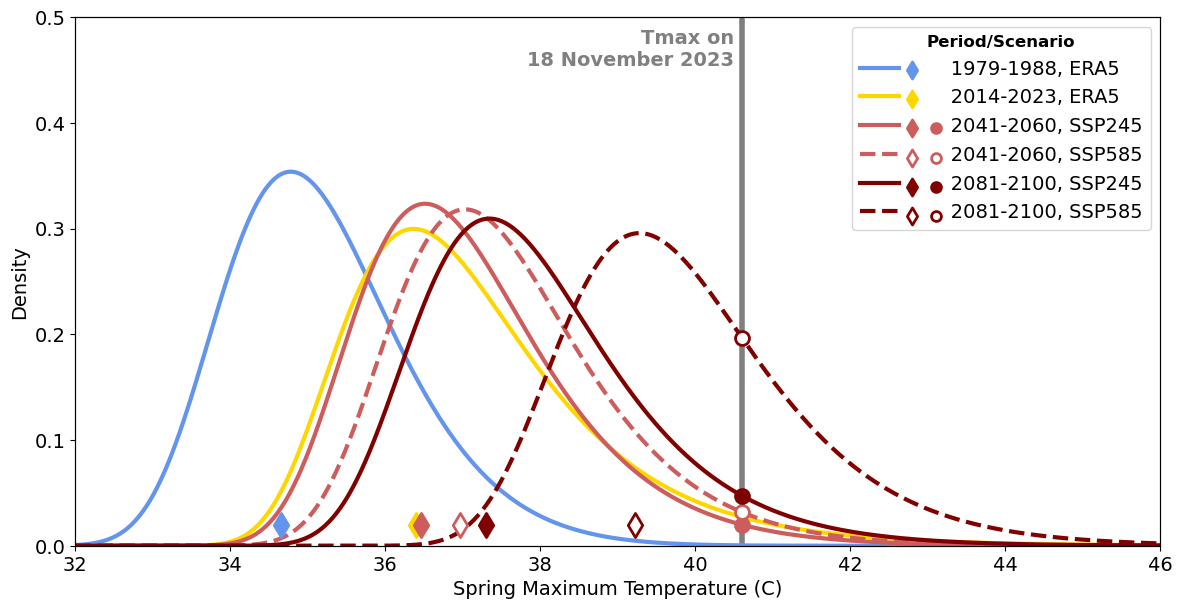

In [55]:
# All projections included
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,1,figsize = (14,7), dpi = 100)

data_toplot = [Tspring_early_yrmax.t2m.values, Tspring_late_yrmax.t2m.values, ssp245_spring_mid_yrmax.tasmax_mid_cent,ssp585_spring_mid_yrmax.tasmax_mid_cent,ssp245_spring_end_yrmax.tasmax_end_cent,ssp585_spring_end_yrmax.tasmax_end_cent]

colors = ['cornflowerblue','gold','indianred','indianred','maroon','maroon']

linestyles = ['solid','solid','solid','dashed','solid','dashed']

##### NOTE NEED TO FIX FIRST ONE FOR SHIFTED PERIOD
labels = ['      1979-1988, ERA5','      2014-2023, ERA5','      2041-2060, SSP245','      2041-2060, SSP585','      2081-2100, SSP245','      2081-2100, SSP585']

alpha = 0.15
xx = np.arange(10,50,0.01)
ext_thresh = 40.6

# Calculate return periods and plot data in both subplots
return_periods = []

for i in range(len(data_toplot)):
    
    data = data_toplot[i] - 273.15

    # Example usage
    fit_period = gev.fit(data)
    pdf_period = gev.pdf(xx, *fit_period)

    axs.plot(xx, pdf_period, color = colors[i], linestyle = linestyles[i], linewidth = 3, label = labels[i])


    if (i == 3) or (i == 5):
        facecolor = 'white'
    else:
        facecolor = colors[i]

    # Plot location parameter
    axs.scatter(fit_period[1],0.02, facecolors = facecolor, edgecolors = colors[i], marker = 'd', s = 150, linewidths = 2, zorder = 100)
    
    print(fit_period[1])
    
    rp = 1 / (1 - gev.cdf(ext_thresh, *fit_period))
    
    return_periods.append(rp)

    # Plot intersection of vertical line with future pdfs
    
    if i > 1:
        axs.scatter(40.6, pdf_period[find_nearest_index(xx,40.6)], facecolors = facecolor, edgecolors = colors[i], marker = 'o', s = 100, linewidths = 2, zorder = 100)
        
axs.set_ylim([0,0.5])
axs.axvline(40.6, c = 'grey', linestyle = 'solid', linewidth = 4, zorder = 0)
axs.text(40.5, 0.47, 'Tmax on\n18 November 2023', fontweight = 'bold', color = 'grey', horizontalalignment = 'right', verticalalignment = 'center')

left_legend = axs.legend(loc = 'upper right', title = 'Period/Scenario')
plt.setp(left_legend.get_title(), fontsize = 12, fontweight = 'bold')

axs.set_xlabel('Spring Maximum Temperature (C)')
axs.set_ylabel('Density')
axs.set_xlim([32,46])

# Plot diamond legend over real legend
ax3 = axs.twinx()
ax3.set_xlim([32,46])
ax3.set_ylim([0,0.5])
ax3.tick_params(right = False , labelright = False)

for i in range(len(data_toplot)):
    
    if (i == 3) or (i == 5):
        facecolor = 'white'
    else:
        facecolor = colors[i]
        
    ax3.scatter(42.8,0.45 - i*0.0276, facecolors = facecolor, edgecolors = colors[i], marker = 'd', s = 75, linewidths = 2)

    if i > 1:
        ax3.scatter(43.1,0.45 - i*0.0276, facecolors = facecolor, edgecolors = colors[i], marker = 'o', s = 50, linewidths = 2)

#plt.savefig('Figure9.png')

plt.show()

In [56]:
print('Shift from early to late historical period = ' + str(round(36.398068772526074 - 34.65740304158574,1)) + '°C')
print('Shift from last ten years to SSP245 midcentury period = ' + str(round(36.46720531184447 - 36.398068772526074,1)) + '°C')
print('Shift from last ten years to SSP585 midcentury period = ' + str(round(37.297915802680315 - 36.398068772526074,1)) + '°C')
print('Shift from last ten years to SSP585 end of century period = ' + str(round(39.22706641898216 - 36.398068772526074,1)) + '°C')

print('SSP245 midcentury return period = ' + str(int(round(return_periods[2],0))) + ' years.')
print('SSP585 midcentury return period = ' + str(int(round(return_periods[3],0))) + ' years.')
print('SSP245 end of century return period = ' + str(int(round(return_periods[4],0))) + ' years.')
print('SSP585 end of century return period = ' + str(int(round(return_periods[5],0))) + ' years.')

Shift from early to late historical period = 1.7°C
Shift from last ten years to SSP245 midcentury period = 0.1°C
Shift from last ten years to SSP585 midcentury period = 0.9°C
Shift from last ten years to SSP585 end of century period = 2.8°C
SSP245 midcentury return period = 51 years.
SSP585 midcentury return period = 33 years.
SSP245 end of century return period = 19 years.
SSP585 end of century return period = 4 years.
